In [1]:
import os 

os.listdir("data")

['HDFCBANK.NS.csv',
 'TATAMOTORS.BO.csv',
 'TATAPOWER.NS.csv',
 'TCS.BO.csv',
 'YESBANK.BO.csv']

In [2]:
import pandas as pd 

lb = 30

data=pd.read_csv("data/TATAPOWER.NS.csv")
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-09-15,242.350006,246.899994,239.899994,245.399994,243.135635,19214950
1,2022-09-16,246.899994,247.750000,232.649994,236.300003,234.119614,58044047
2,2022-09-19,237.500000,237.949997,231.899994,232.350006,230.206070,14016637
3,2022-09-20,235.000000,237.500000,234.149994,235.250000,233.079300,10376536
4,2022-09-21,235.500000,236.600006,230.350006,231.199997,229.066666,14179308
5,2022-09-22,229.100006,233.500000,227.449997,231.649994,229.512512,19648230
6,2022-09-23,231.250000,232.350006,223.550003,224.500000,222.428497,16143866
7,2022-09-26,222.800003,223.550003,212.500000,215.300003,213.313385,22684799
8,2022-09-27,217.300003,219.850006,214.449997,217.500000,215.493088,14097631
9,2022-09-28,215.000000,216.850006,212.750000,213.899994,211.926285,12102060


In [3]:
df=data[["Date","Close"]]
df.head(10)

,Date,Close
0,2022-09-15,245.399994
1,2022-09-16,236.300003
2,2022-09-19,232.350006
3,2022-09-20,235.250000
4,2022-09-21,231.199997
5,2022-09-22,231.649994
6,2022-09-23,224.500000
7,2022-09-26,215.300003
8,2022-09-27,217.500000
9,2022-09-28,213.899994


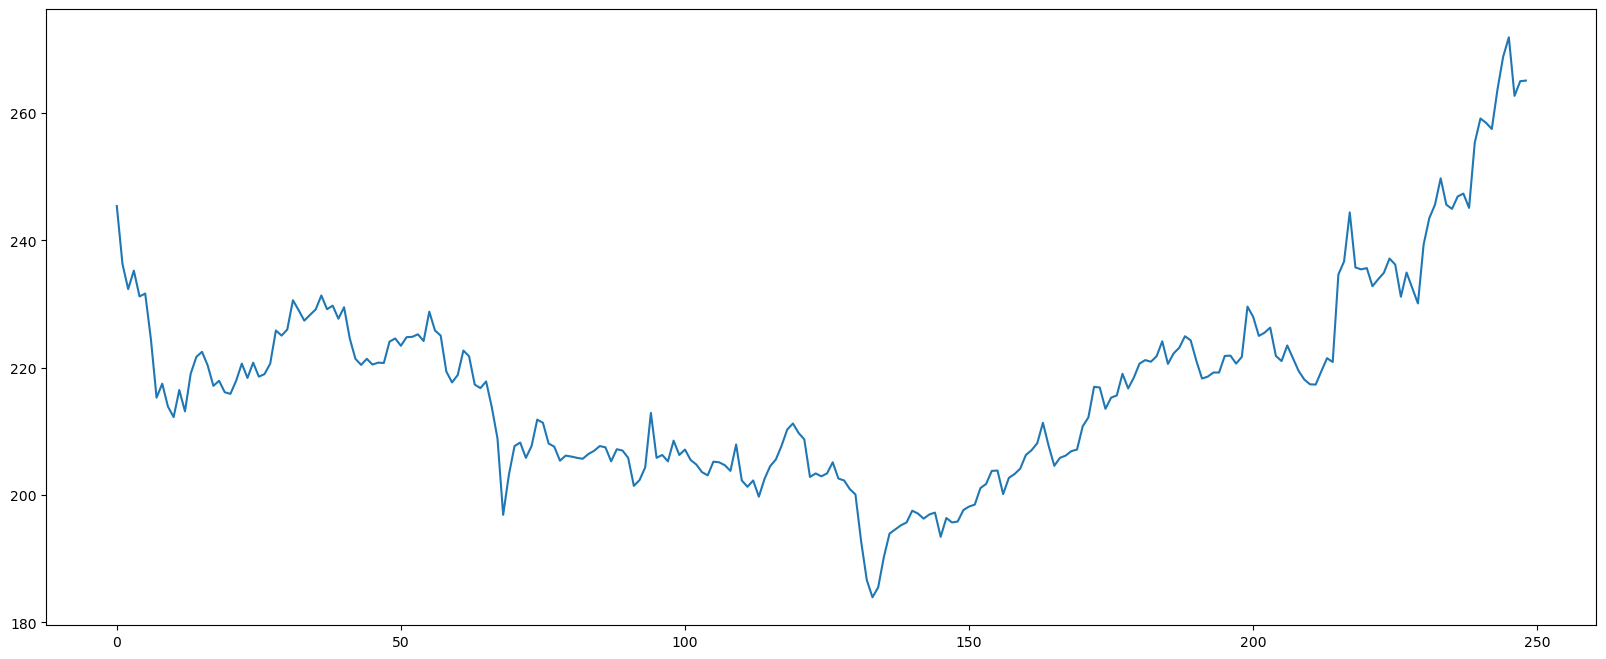

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(df.Close.values)
plt.show()

In [5]:
import numpy as np

# Calculate the mean of series here
mean = np.mean(df.Close.values)

# Adjust the series by downscaling it using mean
adjusted_series = df.Close.values - mean

In [6]:
def format(series: np.array = np.array([]), look_back: int = 5):
    """
    Create a (X, Y) feature-output dataset for ML workflow
    :param series: Numpy (1, ) array
    :param look_back: The number of previous features to be considered for forecasting
    :return: X and Y modelling parameters
    """
    X = []
    Y = []
    for n in range(len(series)):
        k = n + look_back
        if k >= len(series):
            break
        Xtn = series[n:k]
        if len(Xtn) != look_back:
            break
        Ytn = series[k]
        X.append(Xtn)
        Y.append(Ytn)
    return np.array(X), np.array(Y)

In [7]:
# We use previous 30 values to forecast next value
X, y = format(adjusted_series, look_back=lb)
print(X.shape)

# Reshape the time series feature set to be suitable for LSTM model
Xr = X.reshape((X.shape[0], 1, X.shape[1]))

(219, 30)


In [8]:
# Long Short-Term Memoory(LSTM) model
import tensorflow as tf
from keras.models import Sequential
tf.random.set_seed(42)

model = Sequential(name="Proposed_LSTM")

model.add(tf.keras.layers.LSTM(units=512, 
                              activation='relu', 
                              input_shape=(1,lb), return_sequences=True, name="input"))
model.add(tf.keras.layers.LSTM(units=512, 
                              activation='relu', name="lstm"))
model.add(tf.keras.layers.Dense(1, name="output"))

model.compile(loss='mse', optimizer='adam')

In [9]:
history = model.fit(Xr, y, epochs=100, batch_size=128)

Epoch 1/100
2/2 [==============================] - 1s 30ms/step - loss: 262.4128
Epoch 2/100
2/2 [==============================] - 0s 29ms/step - loss: 190.1930
Epoch 3/100
2/2 [==============================] - 0s 26ms/step - loss: 88.1509
Epoch 4/100
2/2 [==============================] - 0s 26ms/step - loss: 91.6878
Epoch 5/100
2/2 [==============================] - 0s 22ms/step - loss: 66.9310
Epoch 6/100
2/2 [==============================] - 0s 21ms/step - loss: 41.7690
Epoch 7/100
2/2 [==============================] - 0s 24ms/step - loss: 39.7626
Epoch 8/100
2/2 [==============================] - 0s 23ms/step - loss: 35.9502
Epoch 9/100
2/2 [==============================] - 0s 25ms/step - loss: 30.5006
Epoch 10/100
2/2 [==============================] - 0s 24ms/step - loss: 21.8224
Epoch 11/100
2/2 [==============================] - 0s 26ms/step - loss: 21.9023
Epoch 12/100
2/2 [==============================] - 0s 24ms/step - loss: 18.1583
Epoch 13/100
2/2 [=================

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Predict the Xr itself to identify fitted series
yhat = model.predict(Xr)

# Upscale the series to identify accurate Closing prices
yhat = yhat + mean
y = y + mean

rmse = sqrt(mean_squared_error(y,yhat))
r2 = r2_score(y, yhat)

print("RMSE: {0}".format(rmse))
print("R2: {0}".format(r2))

7/7 [==============================] - 0s 11ms/step
RMSE: 0.9215755390277677
R2: 0.9969039139527106


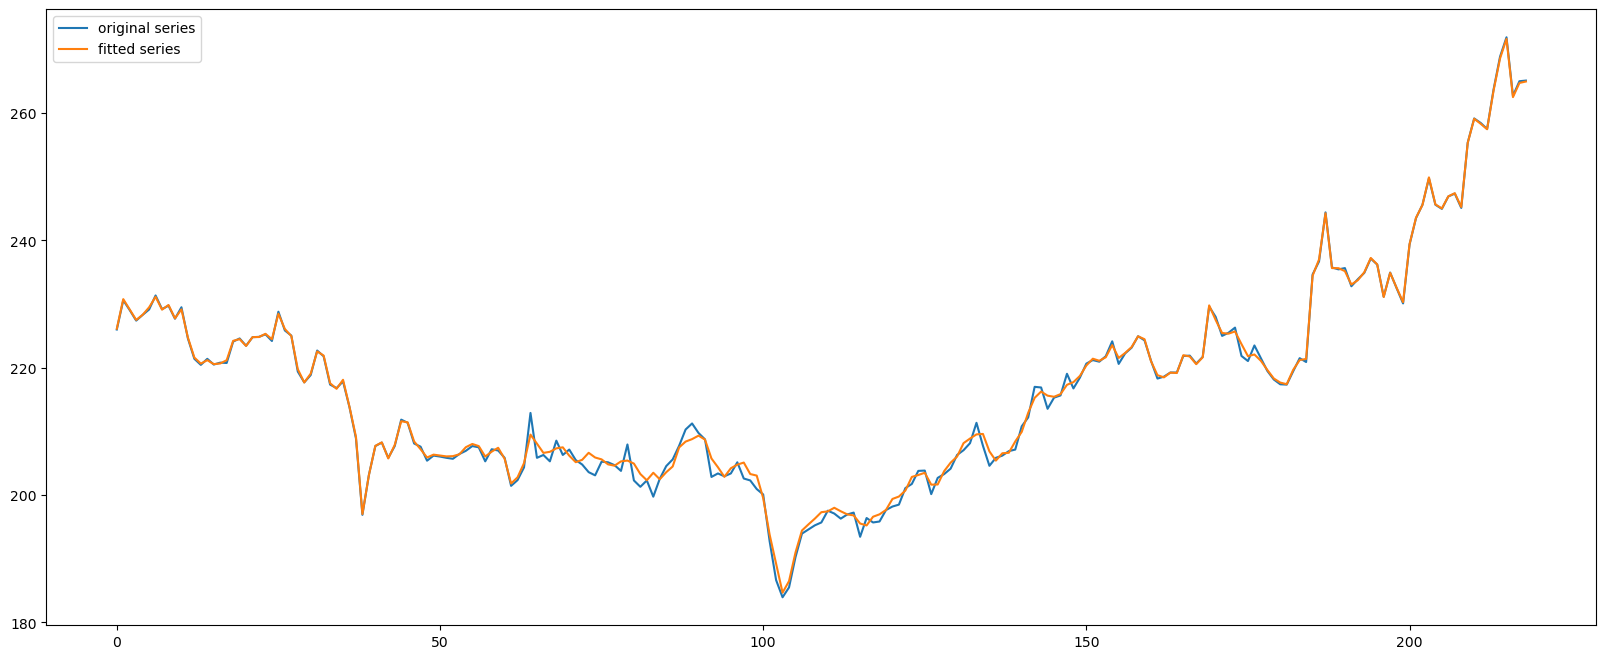

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(y,label="original series")
plt.plot(yhat,label="fitted series")
plt.legend()
plt.show()

In [12]:
m=10
predictions = []
x = Xr[-1]  # Initially take last training input for predicting its immediate next value

for i in range(m):
  x = x.reshape((1, 1, lb))  # Prepare the input for a tensorflow model using reshaping
  prediction = model.predict(x, verbose=False)   # Predict the immediate next value
  x = x.ravel()  # Ravel method converts the 3D array to single dimension array 
  x = np.delete(x, 0)  # Now, we delete first item of the original input
  x = np.append(x, prediction[0][0])  # and append the predicted value to use it for next predictions
  predictions.append(prediction[0][0])   # append the predicted value to 'predictions' list
    
predictions = predictions + mean

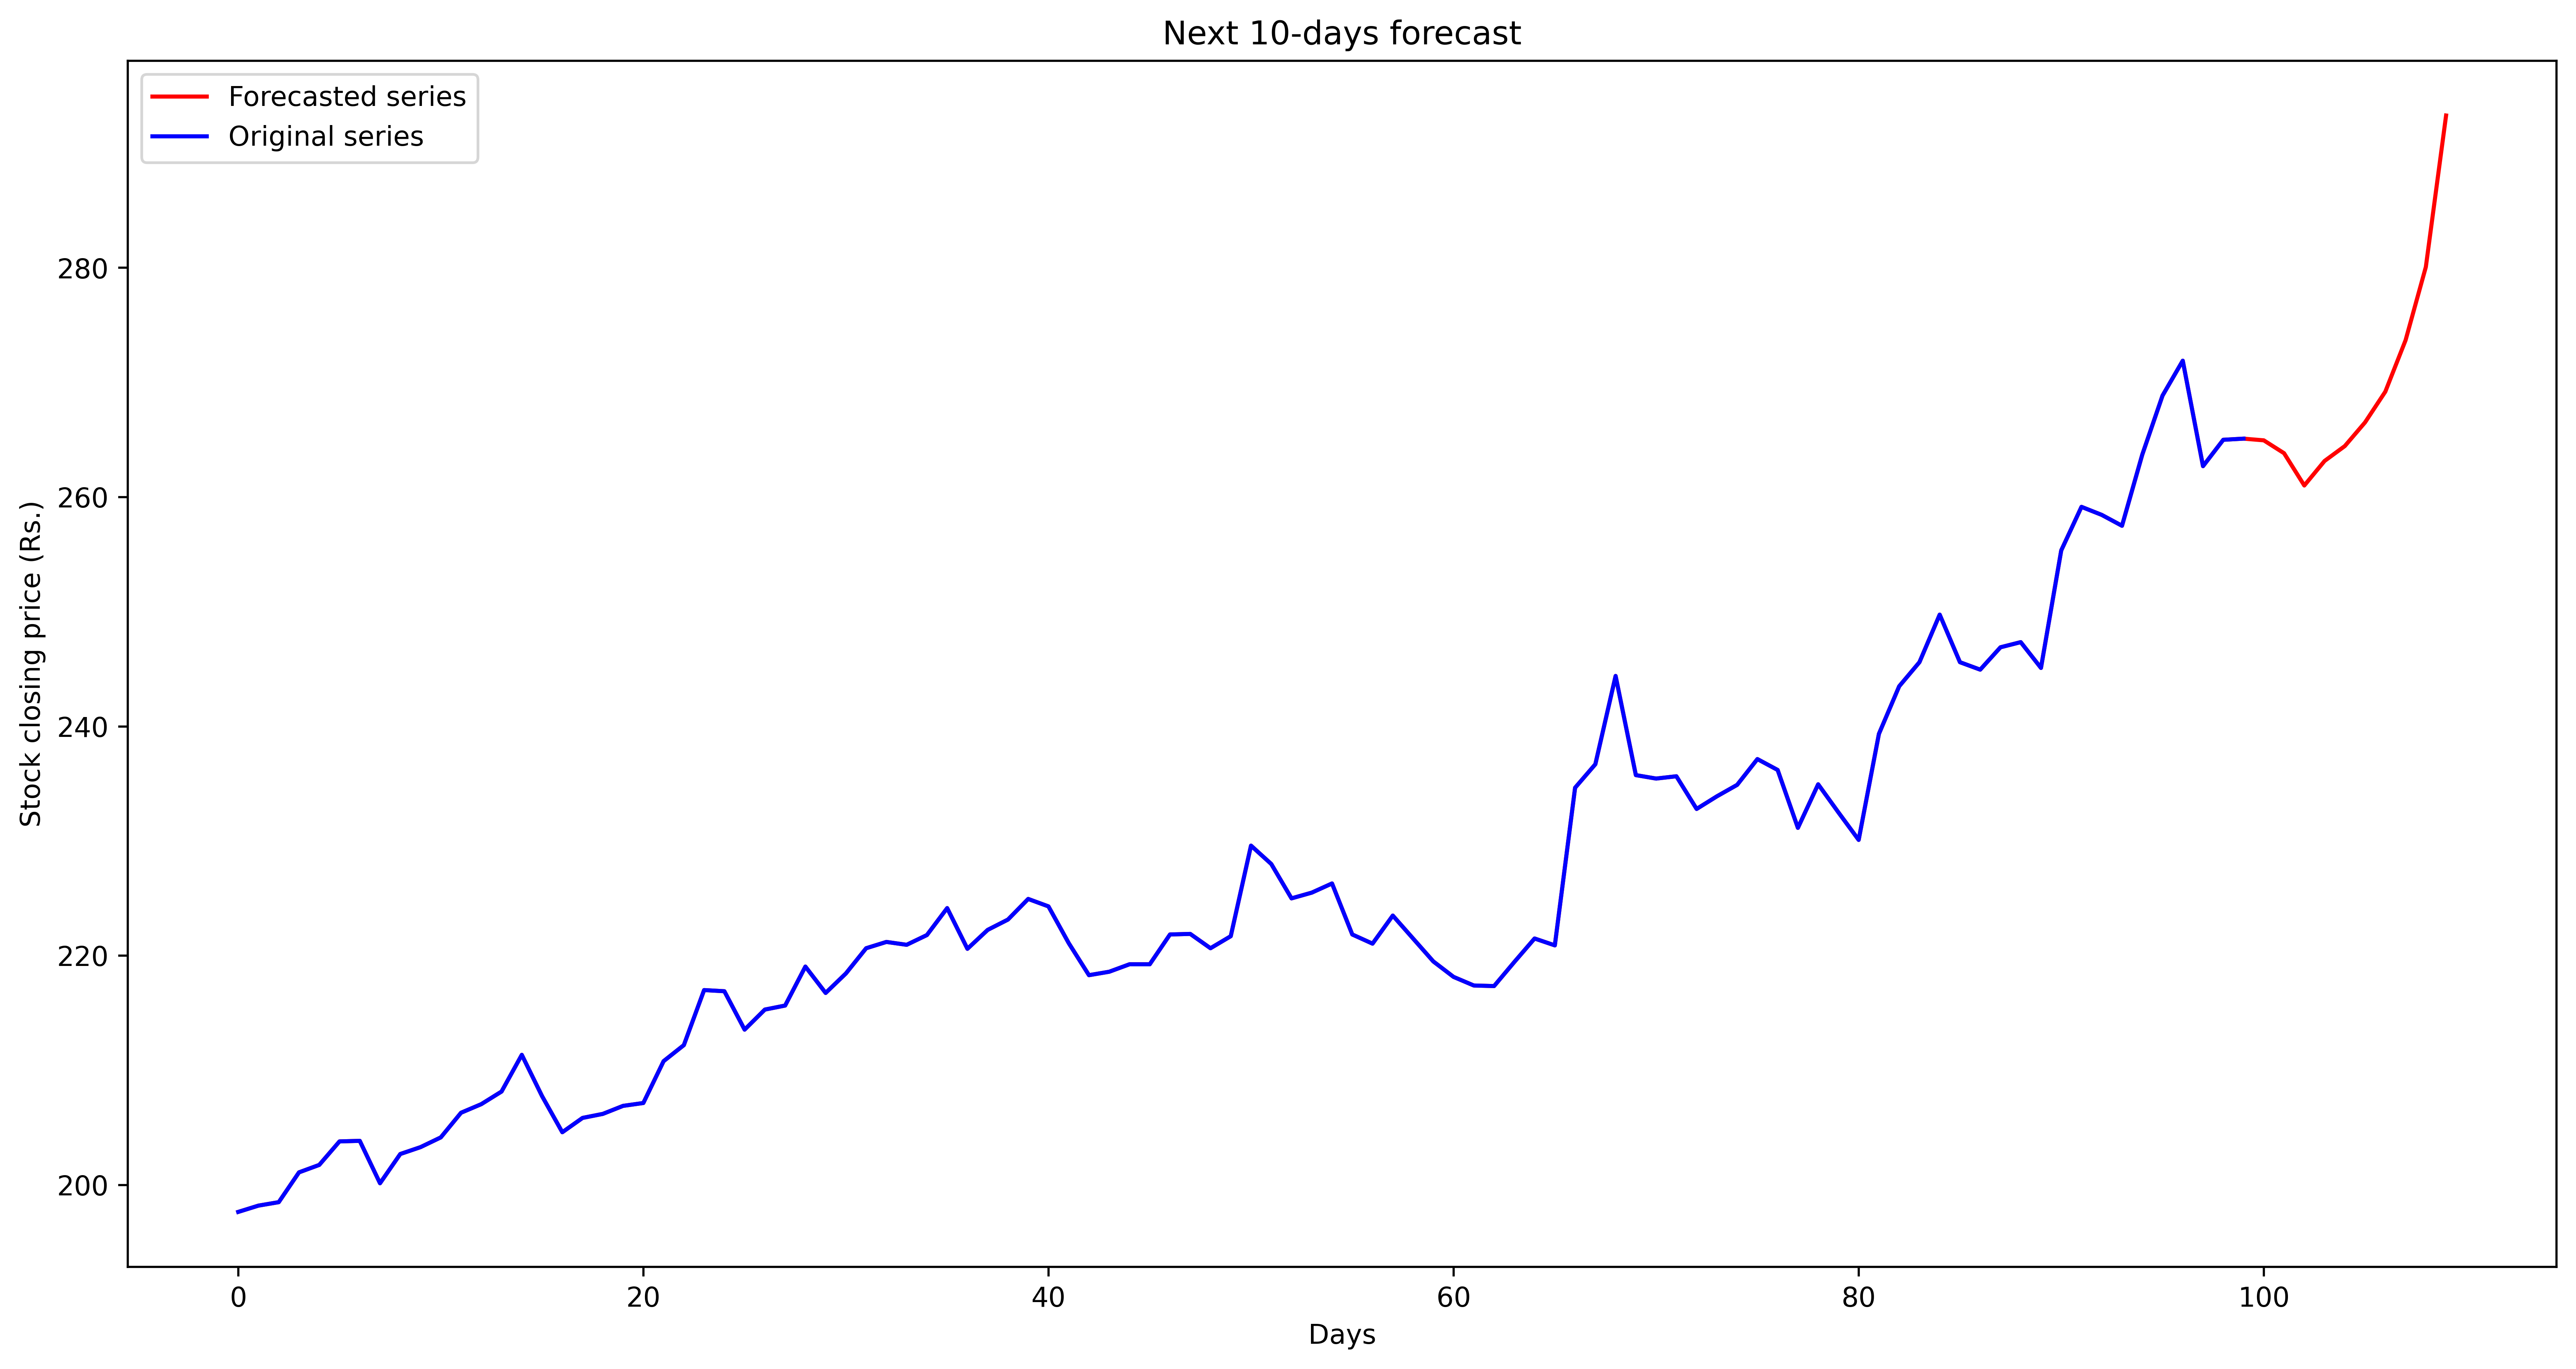

In [13]:
plt.figure(figsize=(16, 8)).set_dpi(512)
plt.plot(np.append(y[-100:], predictions), color='r', label="Forecasted series")
plt.plot(y[-100:], color='b', label="Original series")

plt.ylabel("Stock closing price (Rs.)")
plt.xlabel("Days")
plt.legend()

plt.title("Next 10-days forecast")

plt.show()

In [14]:
m=30
predictions = []
x = Xr[-1]  # Initially take last training input for predicting its immediate next value

for i in range(m):
  x = x.reshape((1, 1, lb))  # Prepare the input for a tensorflow model using reshaping
  prediction = model.predict(x, verbose=False)   # Predict the immediate next value
  x = x.ravel()  # Ravel method converts the 3D array to single dimension array 
  x = np.delete(x, 0)  # Now, we delete first item of the original input
  x = np.append(x, prediction[0][0])  # and append the predicted value to use it for next predictions
  predictions.append(prediction[0][0])   # append the predicted value to 'predictions' list
    
predictions = predictions + mean

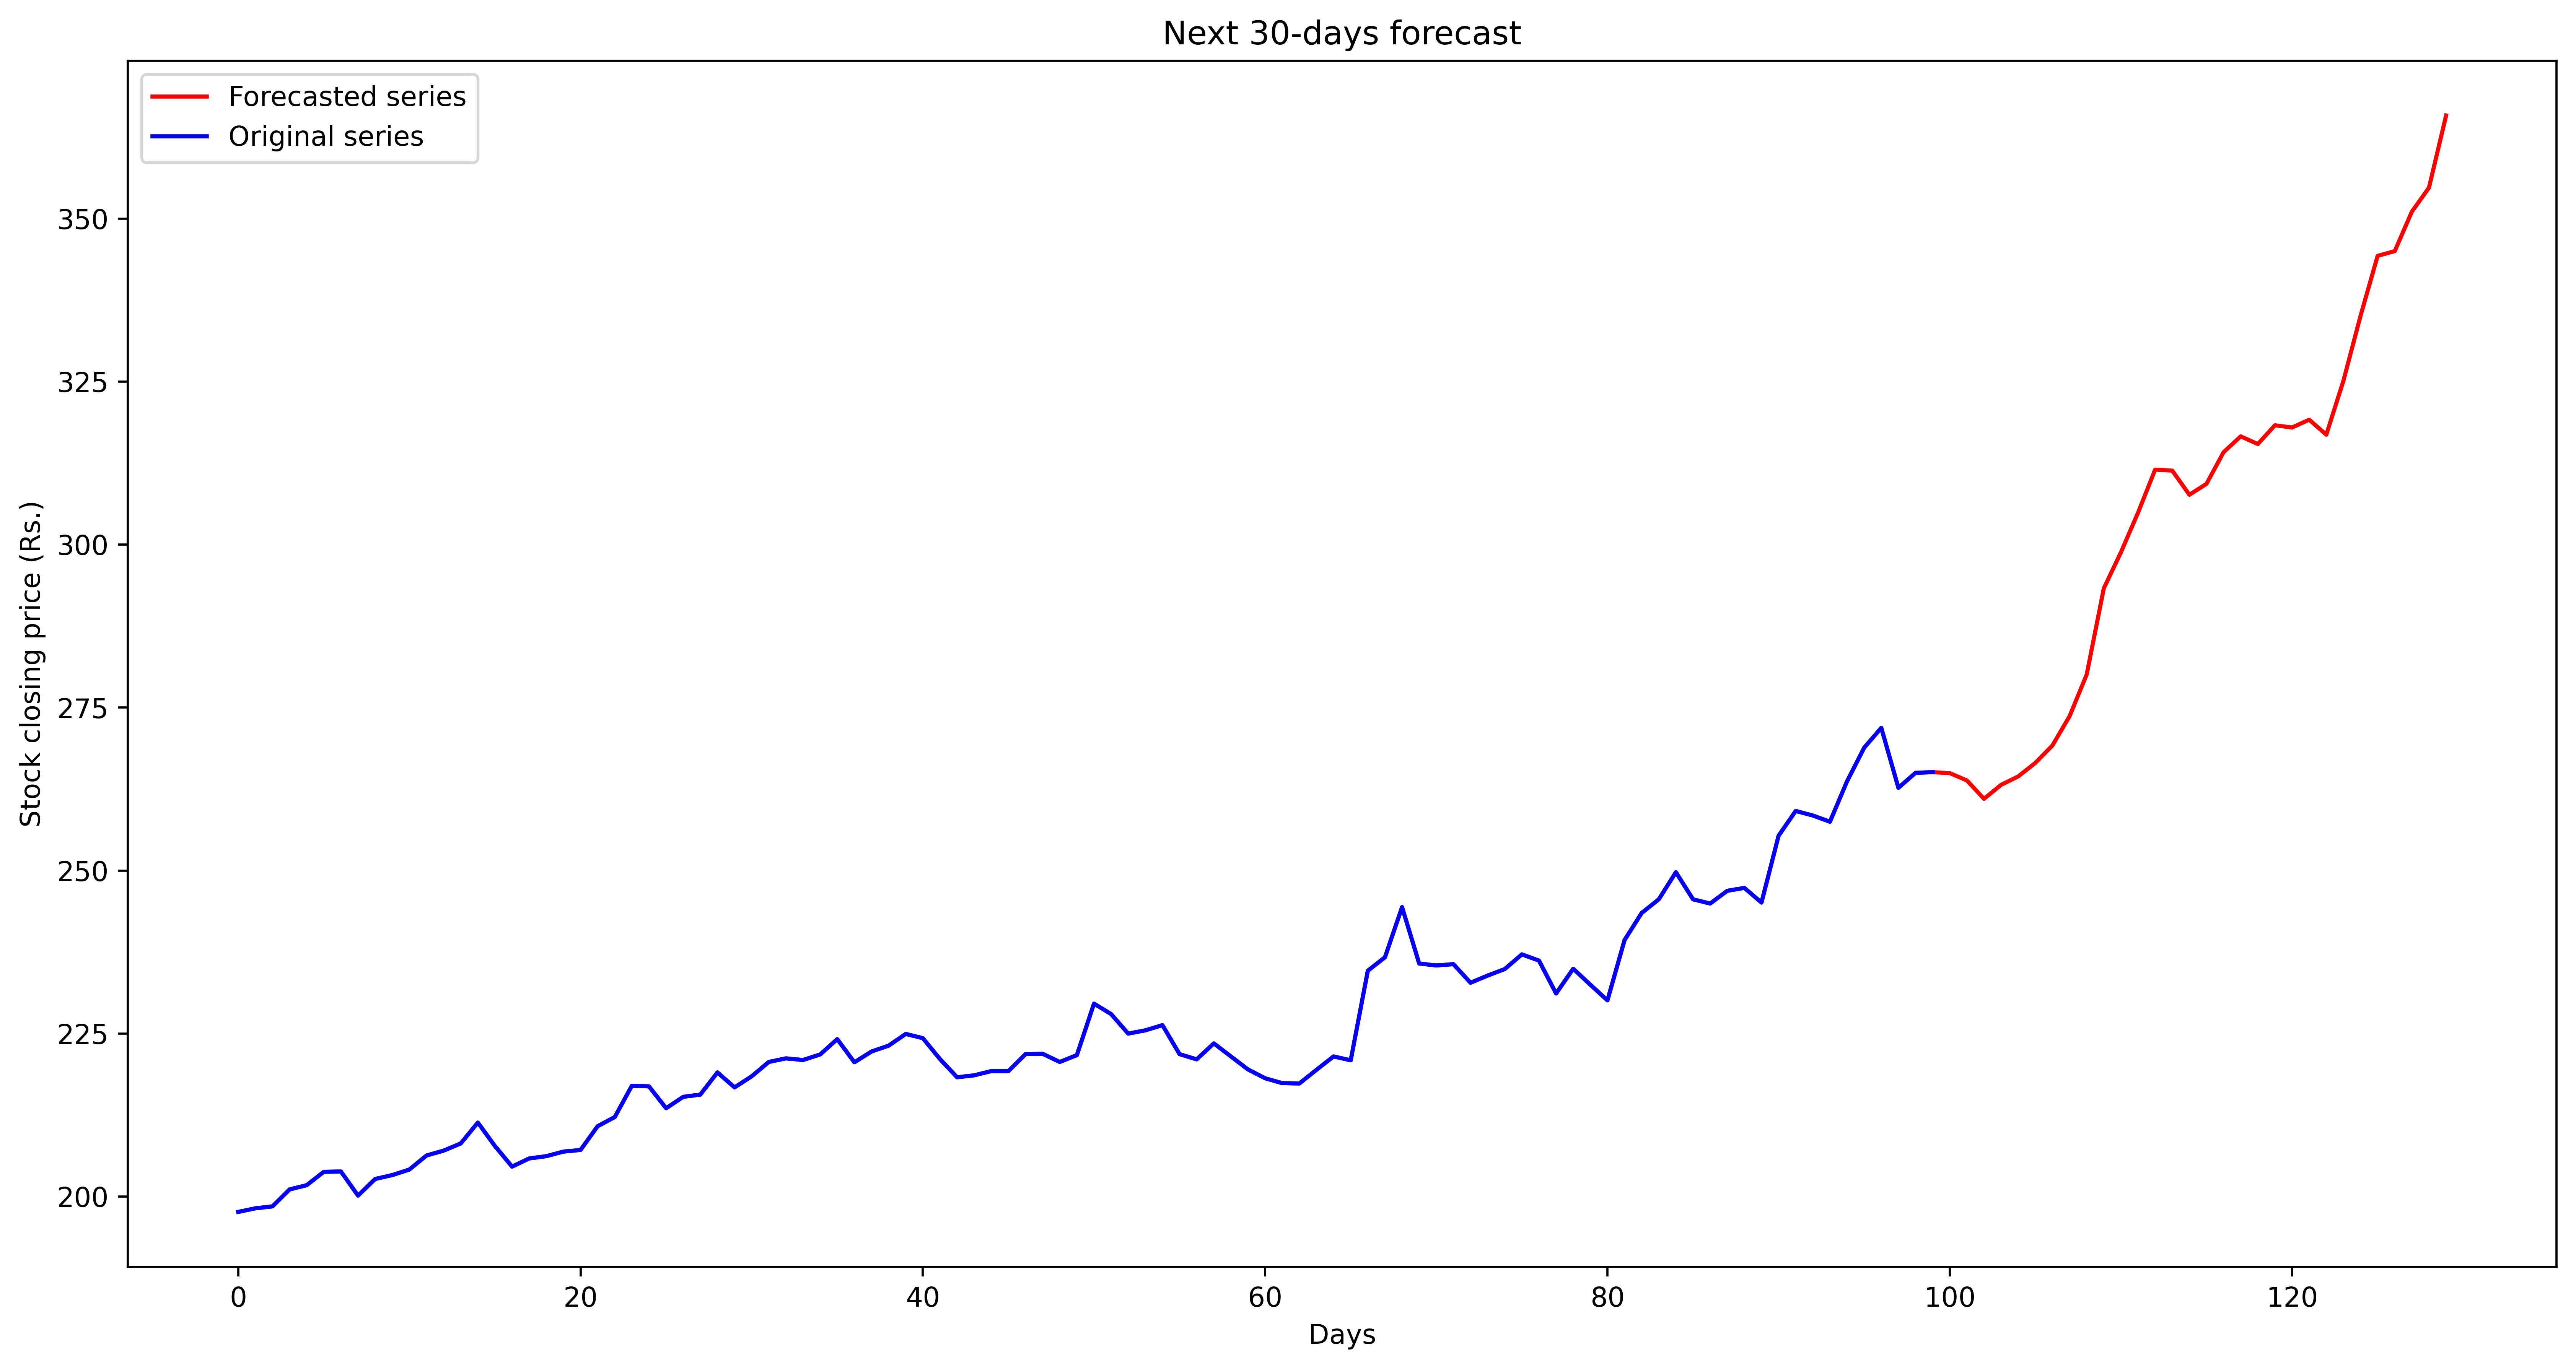

In [15]:
plt.figure(figsize=(16, 8)).set_dpi(512)
plt.plot(np.append(y[-100:], predictions), color='r', label="Forecasted series")
plt.plot(y[-100:], color='b', label="Original series")

plt.ylabel("Stock closing price (Rs.)")
plt.xlabel("Days")
plt.legend()

plt.title("Next 30-days forecast")

plt.show()